<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_MSFT_Rolling_Linear_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
pip install yfinance

In [ ]:
pip install yahoofinancials

In [ ]:
pip install pyfinance

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

# Data

In [ ]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "MSFT",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close
1759,2020-12-31 11:30:00-05:00,220.274994,220.460007,219.679993,219.910004,219.910004,2132707,220.285004
1760,2020-12-31 12:30:00-05:00,219.914993,220.406494,219.800003,220.285004,220.285004,1172462,220.559998
1761,2020-12-31 13:30:00-05:00,220.286896,220.600006,219.880005,220.559998,220.559998,1402907,221.369995
1762,2020-12-31 14:30:00-05:00,220.559998,221.630005,220.529999,221.369995,221.369995,1800116,222.449997
1763,2020-12-31 15:30:00-05:00,221.369995,223.000000,221.160095,222.449997,222.449997,3623446,NaN


In [ ]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [ ]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Datetime,,,,,,,,,,
2020-01-02 09:30:00-05:00,158.779999,159.554993,158.330002,159.100006,159.100006,5598544,159.485001,159.100006,159.100006,0.0
2020-01-02 10:30:00-05:00,159.095001,159.630005,158.990005,159.485001,159.485001,2349407,159.529999,159.292503,159.138506,2349407.0
2020-01-02 11:30:00-05:00,159.479996,159.619995,159.110001,159.529999,159.529999,1784440,159.615005,159.371668,159.177655,4133847.0
2020-01-02 12:30:00-05:00,159.520004,159.800003,159.445007,159.615005,159.615005,1571495,159.934998,159.543335,159.221390,5705342.0
2020-01-02 13:30:00-05:00,159.615005,159.949997,159.529999,159.934998,159.934998,1508504,160.070007,159.693334,159.292751,7213846.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 11:30:00-05:00,220.274994,220.460007,219.679993,219.910004,219.910004,2132707,220.285004,220.563334,222.495879,357081786.0
2020-12-31 12:30:00-05:00,219.914993,220.406494,219.800003,220.285004,220.285004,1172462,220.559998,220.158335,222.274791,358254248.0
2020-12-31 13:30:00-05:00,220.286896,220.600006,219.880005,220.559998,220.559998,1402907,221.369995,220.251668,222.103312,359657155.0


In [ ]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [ ]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end  subperiod           
129  0           0.256320
     1           0.259166
     2           0.259674
     3           0.260378
     4           0.263241
...                   ...
1762 1758        0.876935
     1759        0.873015
     1760        0.877447
     1761        0.879673
     1762        0.889141

[212420 rows x 1 columns]

In [ ]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred

,subperiod,end,predicted
0,0,129,0.256320
1,1,259,0.259145
2,2,390,0.259688
3,3,522,0.260389
4,4,655,0.263237
...,...,...,...
1758,1758,8800,0.876492
1759,1759,7042,0.872508
1760,1760,5283,0.876840
1761,1761,3523,0.879378


In [ ]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.258069
1,1,0.258528
2,2,0.259393
3,3,0.262651
4,4,0.264026
...,...,...
1758,1758,0.873333
1759,1759,0.877151
1760,1760,0.879951
1761,1761,0.888199


In [ ]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod','end'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['MSFT_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,MSFT_RMSE_LIN
0,0.258069,0.256320,0.001749,3.060512e-06,0.001749
1,0.258528,0.259145,-0.000617,3.806219e-07,0.000617
2,0.259393,0.259688,-0.000295,8.675708e-08,0.000295
3,0.262651,0.260389,0.002262,5.116920e-06,0.002262
4,0.264026,0.263237,0.000789,6.228427e-07,0.000789
...,...,...,...,...,...
1758,0.873333,0.876492,-0.003160,9.984168e-06,0.003160
1759,0.877151,0.872508,0.004643,2.155937e-05,0.004643
1760,0.879951,0.876840,0.003111,9.681354e-06,0.003111
1761,0.888199,0.879378,0.008821,7.780363e-05,0.008821


In [ ]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.015365607474902353

## With sentiment

In [ ]:
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df['date'].map(str) + '.' + df['datehour'].map(str) 
df['hour_id']

0        2020-01-02.9
1       2020-01-02.10
2       2020-01-02.11
3       2020-01-02.12
4       2020-01-02.13
            ...      
1759    2020-12-31.11
1760    2020-12-31.12
1761    2020-12-31.13
1762    2020-12-31.14
1763    2020-12-31.15
Name: hour_id, Length: 1764, dtype: object

In [ ]:
sent = pd.read_csv('MSFT_sentiment_hr.csv')
df = pd.merge(df, sent, on = 'hour_id', how = 'left')
df = df.fillna(0)


In [ ]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)
y_pred_sent

,subperiod,predicted
0,0,0.256419
1,1,0.259378
2,2,0.259638
3,3,0.260754
4,4,0.263845
...,...,...
212415,1758,0.876217
212416,1759,0.873239
212417,1760,0.877661
212418,1761,0.878805


In [ ]:
rolling.predicted

end   subperiod
129   0            0.256419
      1            0.259378
      2            0.259638
      3            0.260754
      4            0.263845
                     ...   
1762  1758         0.876217
      1759         0.873239
      1760         0.877661
      1761         0.878805
      1762         0.889342
Name: predicted, Length: 212420, dtype: float64

In [ ]:
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [ ]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})
linear_sent

,period,actual,predicted,predicted_sent
0,0,0.258069,0.256419,0.256419
1,1,0.258528,0.518712,0.259356
2,2,0.259393,0.778952,0.259651
3,3,0.262651,1.042926,0.260732
4,4,0.264026,1.318885,0.263777
...,...,...,...,...
1758,1758,0.873333,4.378186,0.875637
1759,1759,0.877151,3.490984,0.872746
1760,1760,0.879951,2.631163,0.877054
1761,1761,0.888199,1.757155,0.878578


In [ ]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['MSFT_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])
linear_sent

,period,actual,predicted_sent,difference_sent,sq_er_sent,MSFT_RMSE_LIN_SENTIMENT
0,0,0.258069,0.256419,0.001650,2.724026e-06,0.001650
1,1,0.258528,0.259356,-0.000828,6.858038e-07,0.000828
2,2,0.259393,0.259651,-0.000258,6.636195e-08,0.000258
3,3,0.262651,0.260732,0.001920,3.685845e-06,0.001920
4,4,0.264026,0.263777,0.000249,6.202586e-08,0.000249
...,...,...,...,...,...,...
1758,1758,0.873333,0.875637,-0.002304,5.310616e-06,0.002304
1759,1759,0.877151,0.872746,0.004405,1.940433e-05,0.004405
1760,1760,0.879951,0.877054,0.002897,8.391805e-06,0.002897
1761,1761,0.888199,0.878578,0.009621,9.256498e-05,0.009621


In [ ]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.01530790548909441

In [ ]:
MSFT_linear = pd.merge(linear, linear_sent, on = 'actual')
MSFT_linear

,actual,predicted,difference,sq_er,MSFT_RMSE_LIN,period,predicted_sent,difference_sent,sq_er_sent,MSFT_RMSE_LIN_SENTIMENT
0,0.258069,0.256320,0.001749,3.060512e-06,0.001749,0,0.256419,0.001650,2.724026e-06,0.001650
1,0.258528,0.259145,-0.000617,3.806219e-07,0.000617,1,0.259356,-0.000828,6.858038e-07,0.000828
2,0.259393,0.259688,-0.000295,8.675708e-08,0.000295,2,0.259651,-0.000258,6.636195e-08,0.000258
3,0.262651,0.260389,0.002262,5.116920e-06,0.002262,3,0.260732,0.001920,3.685845e-06,0.001920
4,0.264026,0.263237,0.000789,6.228427e-07,0.000789,4,0.263777,0.000249,6.202586e-08,0.000249
...,...,...,...,...,...,...,...,...,...,...
2070,0.873333,0.876492,-0.003160,9.984168e-06,0.003160,1758,0.875637,-0.002304,5.310616e-06,0.002304
2071,0.877151,0.872508,0.004643,2.155937e-05,0.004643,1759,0.872746,0.004405,1.940433e-05,0.004405
2072,0.879951,0.876840,0.003111,9.681354e-06,0.003111,1760,0.877054,0.002897,8.391805e-06,0.002897
2073,0.888199,0.879378,0.008821,7.780363e-05,0.008821,1761,0.878578,0.009621,9.256498e-05,0.009621


In [ ]:
MSFT_linear.describe()

,actual,predicted,difference,sq_er,MSFT_RMSE_LIN,period,predicted_sent,difference_sent,sq_er_sent,MSFT_RMSE_LIN_SENTIMENT
count,2075.000000,2075.000000,2075.000000,2.075000e+03,2075.000000,2075.000000,2075.000000,2075.000000,2.075000e+03,2075.000000
mean,0.616950,0.617048,-0.000099,2.213354e-04,0.009613,917.952289,0.617053,-0.000103,2.197467e-04,0.009575
std,0.227958,0.227642,0.014881,7.225991e-04,0.011357,511.776317,0.227642,0.014827,7.207265e-04,0.011319
min,0.000000,0.019085,-0.082601,3.526736e-11,0.000006,0.000000,0.016876,-0.082300,4.780609e-10,0.000022
25%,0.441554,0.441261,-0.006244,7.299487e-06,0.002702,477.500000,0.440906,-0.006286,7.451478e-06,0.002730
50%,0.707260,0.710269,0.000191,3.817905e-05,0.006179,944.000000,0.710408,0.000161,3.822481e-05,0.006183
75%,0.804399,0.803532,0.006124,1.475920e-04,0.012149,1368.500000,0.803696,0.006079,1.501236e-04,0.012252
max,1.000000,0.992271,0.132144,1.746211e-02,0.132144,1762.000000,0.992313,0.132285,1.749933e-02,0.132285


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

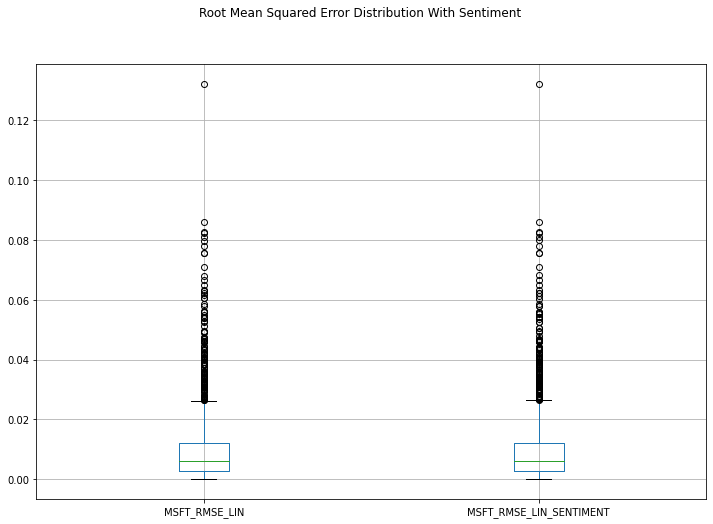

In [ ]:
boxplot = MSFT_linear.boxplot(column=['MSFT_RMSE_LIN', 'MSFT_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [ ]:
MSFT_linear_RMSE = MSFT_linear[['MSFT_RMSE_LIN', 'MSFT_RMSE_LIN_SENTIMENT']]
MSFT_linear_RMSE.describe()

,MSFT_RMSE_LIN,MSFT_RMSE_LIN_SENTIMENT
count,2075.000000,2075.000000
mean,0.009613,0.009575
std,0.011357,0.011319
min,0.000006,0.000022
25%,0.002702,0.002730
50%,0.006179,0.006183
75%,0.012149,0.012252
max,0.132144,0.132285


In [ ]:
MSFT_linear_RMSE.to_csv('MSFT_Linear_Comms_Results.csv')